# Getting Started with Control-M Python Client

## Creating a Workflow

To create a workflow, you need to create an instance of a `Workflow` object. You must specify an environment where Control-M Automation API is installed. If you do not have access to Control-M Automation API in your organization or you are trying it on your own PC, use Control-M Workbench:

In [1]:
from ctm_python_client.core.workflow import Workflow, WorkflowDefaults
from ctm_python_client.core.comm import Environment
from aapi.job import *

In [2]:
workflow = Workflow(
    Environment.create_workbench(),
    WorkflowDefaults(
        run_as='workbench',     # defining workbench as the user to run the jobs by default
    )
)

## Adding Jobs in the Workflow

A job is a task that runs on one or more Agents. Control-M Workbench includes a built-in agent called **worbench**

There are multiple job types, and each has a specific purpose. Some job types require specific plugins, such as JobFileTransfer. Let's start with simple JobCommand which is used to execute an OS command: 

In [3]:
# Creating a JobCommand which outputs "Hello world!"

myJob = JobCommand('MyFirstJob', command='echo "Hello world!"')

# Note that the command could be passed also as a positional argument
# meaning that JobCommand('MyFirstJob', command='echo "Hello world!"')
# is the same of JobCommand('MyFirstJob', 'echo "Hello world!"')

Although a job is created, it is not yet added to the workflow.
A job cannot be added as a root object. It can only exist inside a Folder (or SubFolder, SimpleFolder)
Either create a Folder and add the job to it, or specify a folder name to add the job to when you add it to the workflow:

In [4]:
workflow.add(myJob, inpath='MyFirstFolder')

# this is equivalent of creating the folder then adding the job in it and the folder in the workflow:
#folder = Folder('MyFirstFolder', job_list=[myJob])
#workflow.add(folder)

'MyFirstFolder/MyFirstJob'

## Building and Deploying

The validation of the data is done on the Control-M machine, so let's build the workflow and check that everything is valid:

In [5]:
if workflow.build().is_ok():
    print('The workflow is valid!')

The workflow is valid!


Note that the workflow definitions are still in your code and are not yet added to the Control-M Database.

**Important**: When you deploy the definitions to Control-M, you overwrite existing definitions. Since you do not recieve a warning that you are overwritting definitions, if you are working on a shared environment, do not use folder names that are used by other users

In [6]:
# deploy() also performs build(), so if your intent is to deploy, you may skip the build

if workflow.deploy().is_ok():
    print('The workflow was deployed to Control-M!')    

The workflow was deployed to Control-M!


## Running and checking the output

After the job is deployed, it runs according to its schedule, which is every day by default. You can also choose to run the job anytime. When a job runs, a `RunMonitor` is created, which is used to get the status, output and other information of the run

In [7]:
# the same way deploy() performs build(), run() perform deploy() and build(), so if you want to run a job
# you can directly call run() and it will validate "build()" and deploy in Control-M "deploy()"
run = workflow.run()

In [8]:
# print output
run.print_output('MyFirstJob')

+ echo 'Hello world!'
Hello world!



## Flows

Now that you know how to create and run a job, let's learn how to create workflows.

You use `.connect()` to connect two objects. You can connect Jobs, Folders and SubFolders.
If you want to connect multiple jobs in a chain, you can use the `.chain()` method.

First, let's add jobs without connecting them. Although jobs exisit in the same Folder, there is no exisitng workflow yet.

Then, we can connect any two jobs, Folders, or SubFolders.

Finally we can chain multiple jobs in a sequence.

### Adding jobs without connection

In [9]:
# clear the workflow
workflow.clear_all()

# the .add method returns the path of the job which you can use to connect it with other jobs
firstjob = workflow.add(
    JobCommand('MyFirstJob', command='echo "I come first"'),
    inpath='MyFolder'
)

secondjob = workflow.add(
    JobCommand('MySecondJob', command='echo "I come second"'),
    inpath='MyFolder'
)

If you want to visusalize the flow that you create, you can use Graphviz. Download Graphviz here: https://graphviz.org/download/

**Don't forget to add the binaries folder in PATH. It is prompted in the installation**

If you do not require a visual representation of the flow, skip the installation of Graphviz.

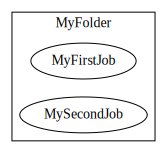

In [10]:
from ctm_python_client.ext.viz import get_graph

get_graph(workflow)

Note that the jobs exist but are not connected. Connect jobs as follows:

### Connecting two Jobs

In [11]:
print(f'Connecting {firstjob} to {secondjob}')
workflow.connect(firstjob, secondjob)

Connecting MyFolder/MyFirstJob to MyFolder/MySecondJob


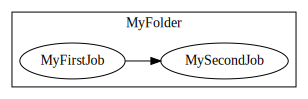

In [12]:
# Now there is a flow
get_graph(workflow)

### Chaining Jobs

`.connect()` enables you to create a flow to/from any object in the workflow, but it is inconvenint to use this method for a chain. Let's learn how to chain multiple jobs. The `.chain()` method uses multiple `.connect()` methods, so the `.chain()` method is a syntactic sugar used to connect a list of jobs.

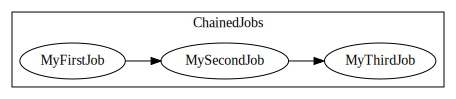

In [13]:
# let's clear the workflow
workflow.clear_all()

workflow.chain(
    [
        JobCommand('MyFirstJob', 'echo "First!"'),
        JobCommand('MySecondJob', 'echo "Second!"'),
        JobCommand('MyThirdJob', 'echo "Third!"', run_as_dummy=True),
    ],
    inpath='ChainedJobs'
)

get_graph(workflow)

## Dummy Jobs and run_as_dummy

Control-M offers two ways to test a workflow and run jobs without running any real task:

- `JobDummy`: Creates a job type that does nothing but you define all the parameters as any other job type.

- `run_as_dummy=True`: Adds a new parameter to any regular job type that makes it run as a dummy job. You can mark `run_as_dummy=False` to make it run again as a regular job.

In [14]:

workflow.clear_all()

workflow.chain(
    [
        JobDummy('Dummy'),
        JobCommand('MyJob1', command='echo "Hello"'),
        JobCommand('MyJob2', command='echo "Hello2"'),
    ],
    inpath='TestJobDummy'
)

run = workflow.run()

import time
time.sleep(2) # Give some time for the flow to finish

# No output for a JobDummy
output = run.get_output('Dummy')
assert output is None

# Output for a JobCommand
output = run.get_output('MyJob1')
assert output is not None
print(output)

# Output for a JobCommand
output = run.get_output('MyJob2')
assert output is not None
print(output)


+ echo Hello
Hello

+ echo Hello2
Hello2



In [15]:
workflow.get('TestJobDummy/MyJob2').run_as_dummy = True
run = workflow.run()

import time
time.sleep(2) # Give some time for the flow to finish

# No output for a JobDummy
output = run.get_output('Dummy')
assert output is None

# Output for a JobCommand
output = run.get_output('MyJob1')
assert output is not None
print(output)

# Output for a JobCommand
output = run.get_output('MyJob2')
assert output is None       # MyJob2 was marked to run as dummy, we should not receive any output for this job

+ echo Hello
Hello

